In [110]:
# Libraries for prac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Q1
NOTE: You can either use brute force approach or broadcasting (vectorization) approach

In [111]:
# TODO: Load train and test data

train_inputs_path = os.path.join(os.getcwd(), 'W12/train_inputs')
train_outputs_path = os.path.join(os.getcwd(), 'W12/train_outputs')
test_inputs_path = os.path.join(os.getcwd(), 'W12/test_inputs')

train_inputs = pd.read_csv(train_inputs_path, header=None)
train_outputs = pd.read_csv(train_outputs_path, header=None)
test_inputs = pd.read_csv(test_inputs_path, header=None)

### Brute force approach

In [112]:
# Function K implementation by brute-force approach.
def K_1(X, X_star, l):
    """
    Compute the squared exponential covariance matrix between X and X_star.

    Args:
    X (ndarray): An n x d array containing n data points with d dimensions.
    X_star (ndarray): An m x d array containing m data points with d dimensions.
    l (float): Length-scale hyperparameter.

    Returns:
    ndarray: An n x m array containing the covariance between points in X and X_star.
    """
    n, d = X.shape
    m = X_star.shape[0]
    output = np.zeros((n, m))

    # TODO: Implement function K by brute-force. Hint: 2 for loops and looping over possible combination of pth row of X and the qth row of X∗.

    for i in range(n):
        for j in range(m):
            output[i, j] = np.exp(-1 * (1 / 2 * l * l) * np.sum((X[i] - X_star[j]) * (X[i] - X_star[j])))

    return output

In [113]:
# Example for testing
X = np.array([[1, 2], [3, 4], [5, 6]])
X_star = np.array([[2, 3], [4, 5]])
l = 1.0
covariance_matrix = K_1(X, X_star, l)
print(covariance_matrix)

[[3.67879441e-01 1.23409804e-04]
 [3.67879441e-01 3.67879441e-01]
 [1.23409804e-04 3.67879441e-01]]


### Broadcasting approach

In [114]:
def K_2(X, X_star, l):
    """
    Compute the squared exponential covariance matrix between X and X_star.

    Args:
    X (ndarray): An n x d array containing n data points with d dimensions.
    X_star (ndarray): An m x d array containing m data points with d dimensions.
    l (float): Length-scale hyperparameter.

    Returns:
    ndarray: An n x m array containing the covariance between points in X and X_star.
    """
    n, d = X.shape
    m = X_star.shape[0]

    # Reshape X and X_star to facilitate broadcasting
    X_reshaped = X.reshape(n, 1, d)# Shape: (n, 1, d)
    X_star_reshaped = X_star.reshape(1, m, d)  # Shape: (1, m, d)

    # Compute pairwise squared Euclidean distances
    distances = np.sum(np.power(X_reshaped - X_star_reshaped , 2), axis=2) # Shape: (n, m)

    # Compute covariance matrix using squared exponential kernel
    output = np.exp(-1 * (1 / 2 * l * l) * distances)

    return output

In [115]:
# Example for testing
X = np.array([[1, 2], [3, 4], [5, 6]])
X_star = np.array([[2, 3], [4, 5]])
l = 1.0
covariance_matrix = K_2(X, X_star, l)
print(covariance_matrix)

[[3.67879441e-01 1.23409804e-04]
 [3.67879441e-01 3.67879441e-01]
 [1.23409804e-04 3.67879441e-01]]


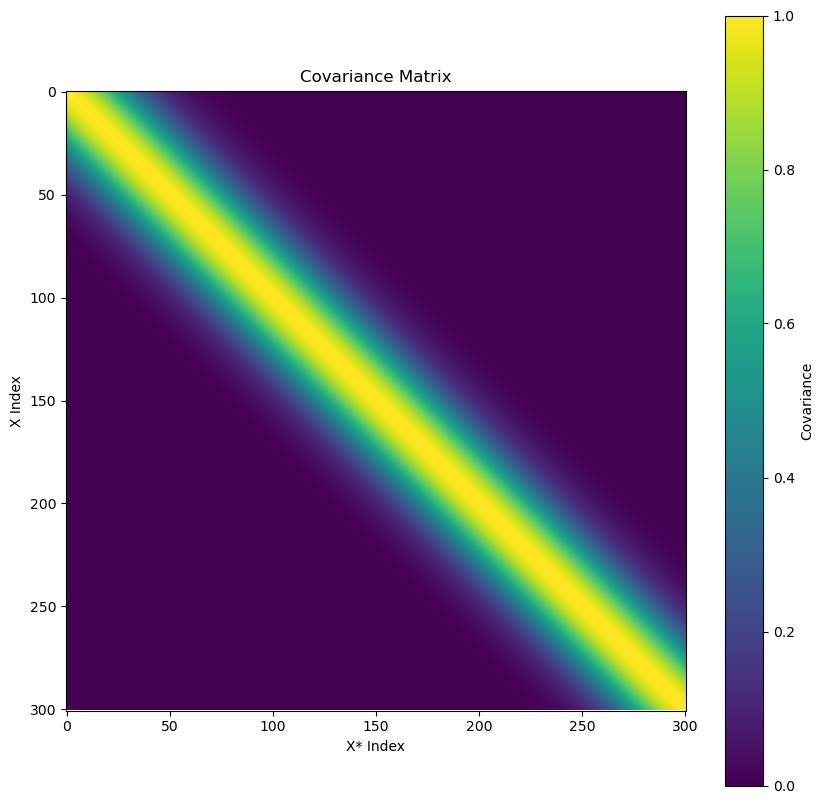

In [116]:
# Example for test-inputs
test_inputs_np = test_inputs.values
covariance_matrix = K_2(test_inputs_np, test_inputs_np, l=1.0)

# Visualize the covariance matrix
plt.figure(figsize=(10, 10))
plt.imshow(covariance_matrix, cmap='viridis')
plt.colorbar(label='Covariance')
plt.title('Covariance Matrix')
plt.xlabel('X* Index')
plt.ylabel('X Index')
plt.show()

## Q2

In [117]:
def sample_prior(X, l, N):
    """
    Sample from the Gaussian Process prior with mean 0 and squared exponential covariance function.

    Args:
    X (ndarray): An n x d array containing n data points with d dimensions.
    l (float): Length-scale hyperparameter.
    N (int): Number of desired samples.

    Returns:
    ndarray: An N x n array representing N samples from the GP prior.
    """

    # TODO: compute mean and covariance_matrix

    mean = np.zeros(X.shape[0])

    covariance_matrix = K_2(X, X, l)

    # TODO: compute sample

    samples = np.random.multivariate_normal(mean, covariance_matrix, size=N)
    
    return samples

## Q3

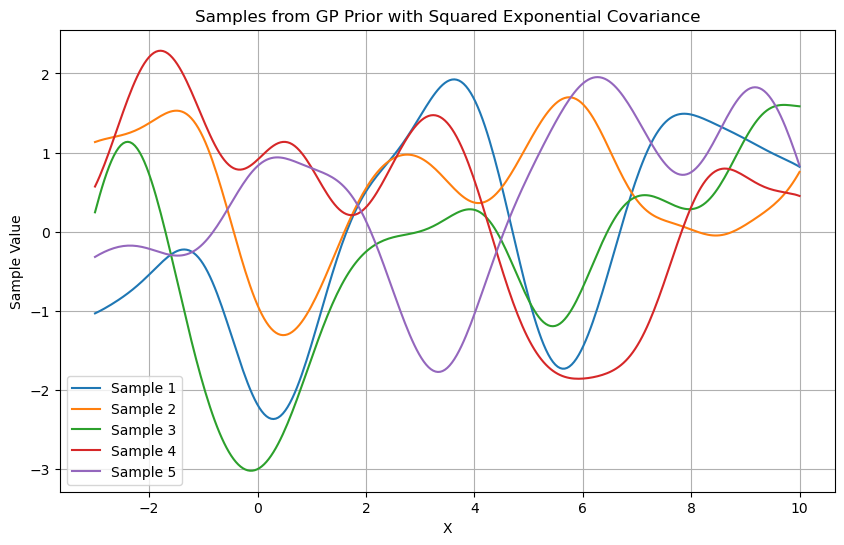

In [118]:
# TODO: Testing sample_prior()

N = 5

X = test_inputs.to_numpy()

prior_samples = sample_prior(X, l=1.0, N=N)

# Plot samples
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(X, prior_samples[i], label=f'Sample {i+1}')
plt.title('Samples from GP Prior with Squared Exponential Covariance')
plt.xlabel('X')
plt.ylabel('Sample Value')
plt.legend()
plt.grid(True)
plt.show()

## Q4

In [119]:
def predictive_mean(X, y, X_star, l, sigma_n):
    """
    Compute the predictive mean of the posterior predictive distribution.

    Args:
    X (ndarray): An n x d array containing n training input data points with d dimensions.
    y (ndarray): An n x 1 array containing n training target data points.
    X_star (ndarray): An m x d array containing m prediction input data points with d dimensions.
    l (float): Length-scale hyperparameter.
    sigma_n (float): Noise parameter.

    Returns:
    ndarray: An m x 1 array representing the mean of the posterior predictive distribution at X_star.
    """
    # TODO: Compute covariance matrices

    cov_star_X = K_2(X_star, X, l)
    cov_X_X = K_2(X, X, l)

    # TODO: Calculate predictive mean

    predictive_mean = np.dot(np.dot(cov_star_X, np.linalg.inv(cov_X_X + np.dot(np.power(sigma_n, 2), np.identity(cov_X_X.shape[0])))), y)

    return predictive_mean

## Q5

In [136]:
def predictive_cov(X, y, X_star, l, sigma_n):
    """
    Compute the covariance of the posterior predictive distribution.

    Args:
    X (ndarray): An n x d array containing n training input data points with d dimensions.
    y (ndarray): An n x 1 array containing n training target data points.
    X_star (ndarray): An m x d array containing m prediction input data points with d dimensions.
    l (float): Length-scale hyperparameter.
    sigma_n (float): Noise parameter.

    Returns:
    ndarray: An m x m array representing the covariance of the posterior predictive distribution at X_star.
    """
    # TODO: Compute covariance matrices

    cov_star_star = K_2(X_star, X_star, l)
    cov_X_star = K_2(X, X_star, l)
    cov_star_X = K_2(X_star, X, l)
    cov_X_X = K_2(X, X, l)

    # TODO: Calculate predictive covariance

    predictive_covariance = cov_star_star - np.dot(np.dot(cov_star_X, np.linalg.inv(cov_X_X + np.dot(np.power(sigma_n, 2), np.identity(cov_X_X.shape[0])))), cov_X_star)

    return predictive_covariance

## Q6

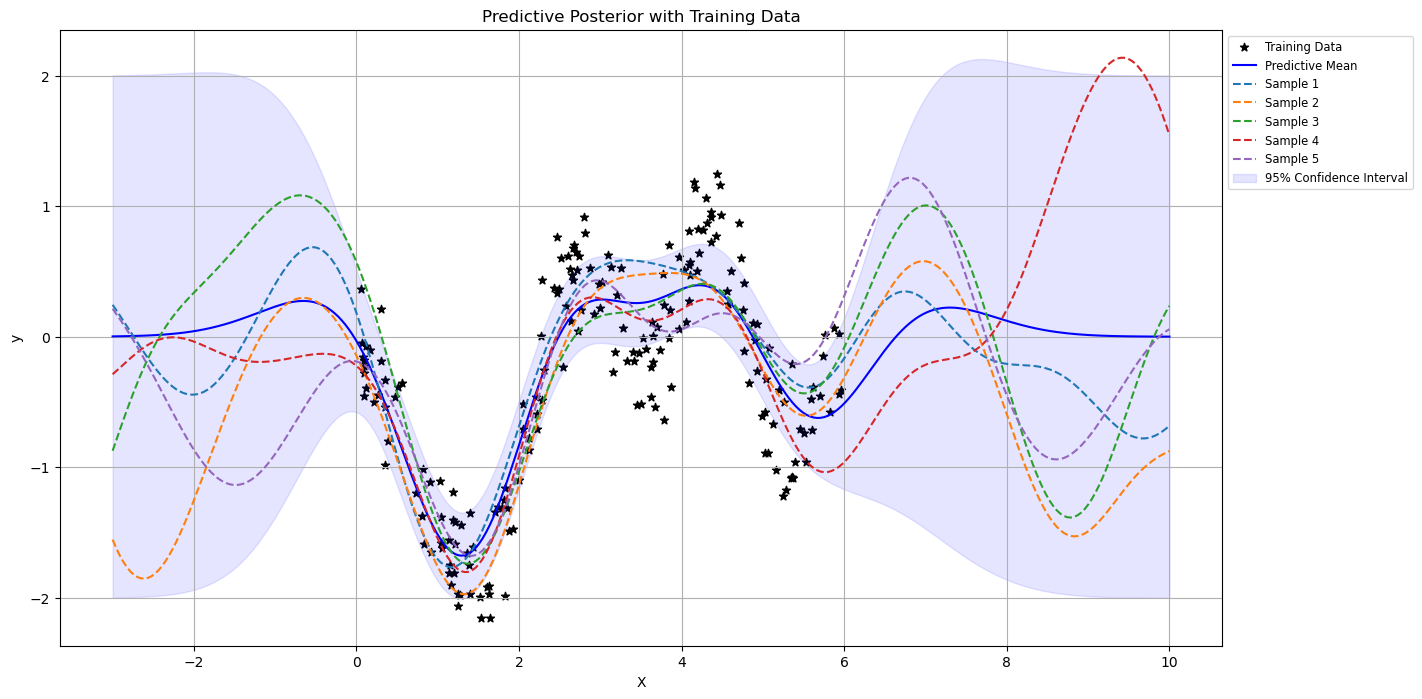

In [141]:
# Test inputs
X_train = train_inputs.values  # Training input data
y_train = train_outputs.values  # Training target data
X_test = test_inputs.values  # Test input data
l = 1.0  # Length-scale parameter
sigma_n = 1.0  # Noise parameter
N = 5  # Number of samples

# TODO: Compute predictive mean and covariance

mean = predictive_mean(X_train, y_train, X_test, l, sigma_n).ravel()
covariance = predictive_cov(X_train, y_train, X_test, l, sigma_n)

# TODO: Generate samples from the predictive posterior distribution

samples = np.random.multivariate_normal(mean, covariance, size=N)

# Plot the training data, mean, and samples
plt.figure(figsize=(15, 8))
plt.scatter(X_train, y_train, color='black', label='Training Data', marker='*')
plt.plot(X_test, mean, color='blue', label='Predictive Mean')
for i in range(N):
    plt.plot(X_test, samples[i], linestyle='--', label=f'Sample {i+1}')
plt.fill_between(X_test.flatten(), mean.flatten() - 2 * np.sqrt(np.diag(covariance)),
                 mean.flatten() + 2 * np.sqrt(np.diag(covariance)),
                 color='blue', alpha=0.1, label='95% Confidence Interval')
plt.title('Predictive Posterior with Training Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()